### Import necessary libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

### Check if GPU is available or not

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Define dataset directory

In [3]:
dataset_path = "../../dataset/ctscan/3A_images_resized/rl_dataset/"

### Define some parameters for model

In [5]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 64
EPOCHS = 20
BASE_MODELS = ["vgg16", "resnet101", "densenet169"]

### Create object of ImageDataGenerator to load the data for training and validation

In [7]:
datagen = ImageDataGenerator(
  rescale=1./255,
  width_shift_range=0.1,
  height_shift_range=0.1,
  # shear_range=0.1,
  zoom_range=0.2,
  # horizontal_flip=True,
  fill_mode='nearest',
  validation_split=0.2
)

### Load the training data from dataset folder (split images from this folder as specified in datagen object)

In [9]:
train_generator = datagen.flow_from_directory(
  dataset_path + "child_data",
  subset="training",
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

Found 1601 images belonging to 3 classes.


### Load the model validation data from dataset folder (split images from this folder as specified in datagen object)

In [11]:
val_generator = datagen.flow_from_directory(
  dataset_path + "child_data",
  subset="validation",
  class_mode='categorical',
  target_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

Found 399 images belonging to 3 classes.


### Examine the classes

In [13]:
class_names = ['Covid19', 'Normal', 'Pneumonia']
classes = train_generator.class_indices
print(classes)
NUM_CLASSES = len(classes)

{'Covid19': 0, 'Normal': 1, 'Pneumonia': 2}


In [14]:
# base_model = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet')
# base_model = ResNet101(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights='imagenet')
# base_model = DenseNet169(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet')

### Define a function to choose base Model for transfer learning

In [15]:
def get_model(model_sel):
  if model_sel == 1:
    vgg_pre_t = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet')
    return vgg_pre_t, 25088

  elif model_sel == 2:
    resnet_pre_t = ResNet101(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights='imagenet')
    return resnet_pre_t, 100352

  elif model_sel == 3:
    densenet169_pre_t = DenseNet169(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights ='imagenet' )
    return densenet169_pre_t, 81536

### Choose one Model

In [16]:
select_model = 1 # int(input("Enter the number for: \n 1) VGG16 \n 2) Resnet101  \n 3) Densenet169 "))

### Get the chosen Model

In [17]:
base_model, feature_size = get_model(select_model)

### Freeze the layers of base model as training is not needed for them

In [18]:
print(len(base_model.layers))
for layer in base_model.layers:
  layer.trainable = False

19


### Make some customization on the output layer of base Model

In [19]:
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = MaxPooling2D()(x)
# x = Dense(1024, activation='relu')(x)
x = Flatten()(x)

predictions = Dense(NUM_CLASSES, activation='softmax')(x)
print(x.shape, predictions.shape)

(None, 25088) (None, 3)


### Initialize model based on base Model

In [20]:
model = Model(inputs=base_model.input, outputs=predictions)

### Compile Model

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train Model

In [22]:
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=EPOCHS,
          validation_data=val_generator,
          validation_steps=len(val_generator))

Epoch 1/20
26/26 [==============================] - 47s 2s/step - loss: 1.0640 - accuracy: 0.6371 - val_loss: 0.4104 - val_accuracy: 0.8496
Epoch 2/20
26/26 [==============================] - 18s 708ms/step - loss: 0.1844 - accuracy: 0.9388 - val_loss: 0.3713 - val_accuracy: 0.8095
Epoch 3/20
26/26 [==============================] - 18s 702ms/step - loss: 0.1109 - accuracy: 0.9713 - val_loss: 0.3580 - val_accuracy: 0.8195
Epoch 4/20
26/26 [==============================] - 18s 701ms/step - loss: 0.1013 - accuracy: 0.9706 - val_loss: 0.3285 - val_accuracy: 0.8797
Epoch 5/20
26/26 [==============================] - 18s 697ms/step - loss: 0.0672 - accuracy: 0.9813 - val_loss: 0.2846 - val_accuracy: 0.8797
Epoch 6/20
26/26 [==============================] - 18s 698ms/step - loss: 0.0498 - accuracy: 0.9888 - val_loss: 0.2786 - val_accuracy: 0.8772
Epoch 7/20
26/26 [==============================] - 18s 695ms/step - loss: 0.0468 - accuracy: 0.9888 - val_loss: 0.3411 - val_accuracy: 0.8496
Ep

### Visualize the training process from accuracy

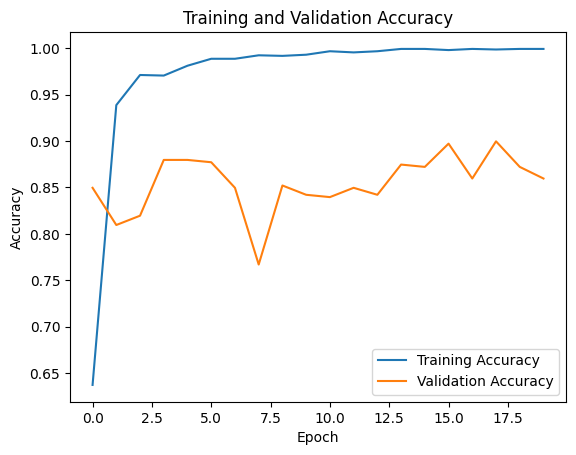

In [23]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Visualize the training process from loss

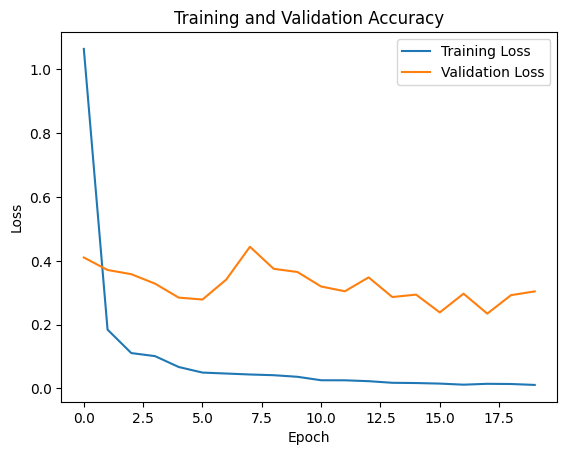

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save Model

In [25]:
val_accuracy_list = history.history['val_accuracy']
val_accuracy = val_accuracy_list[-1] # last epoch value

In [30]:
model_name = "./models/ctscan_" + BASE_MODELS[select_model-1] + "_" + str(BATCH_SIZE) + "_" + str(EPOCHS) + "_child_acc_" + str(round(val_accuracy * 100, 1)) + ".h5"
model.save(model_name)
print(model_name)

./models/ctscan_vgg16_64_20_child_acc_86.0.h5


### Import necessary models for evaluations

In [27]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

### Evaluate the Model

In [28]:
val_data, val_labels = [], []
for _ in range(len(val_generator)):
    batch_data, batch_labels = val_generator.next()
    val_data.append(batch_data)
    val_labels.append(batch_labels)

val_data = np.concatenate(val_data)
val_labels = np.concatenate(val_labels)

# Make predictions on the validation set
val_predictions = model.predict(val_data)

13/13 [==============================] - 2s 32ms/step


In [2]:
# Convert predicted probabilities to predicted class labels
val_predicted_labels = (val_predictions > 0.5).astype(int)  # Thresholding at 0.5

p_l = [np.where(x == 1)[0][0] if len(np.where(x == 1)[0])> 0 else 0 for x in val_predicted_labels]
t_l = [np.where(x == 1)[0][0] for x in val_labels]

# loss, accuracy = model.evaluate(val_generator, steps=len(val_generator))
accuracy = accuracy_score(val_labels, val_predicted_labels)

# Calculate precision
precision = precision_score(val_labels, val_predicted_labels, average='micro')

# Calculate F1 score
f1 = f1_score(val_labels, val_predicted_labels, average='micro')

# Calculate AUC-ROC
auc_roc = roc_auc_score(val_labels, val_predictions, average='micro')

# Calculate confusion matrix
# conf_matrix = multilabel_confusion_matrix(val_labels, val_predicted_labels)
conf_matrix = confusion_matrix(t_l, p_l)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
# print("Loss:", loss)
print("Precision:", precision)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Confusion Matrix:\n", conf_matrix)

NameError: name 'val_predictions' is not defined

### Print Model Summary

In [27]:
# loaded_model.summary()